# Visualization of the 

In [1]:
import matplotlib.pyplot as plt
import torch
import os
import dgl
import numpy as np
import sys
from torch.utils.data import DataLoader
#sys.path.append("../")

In [2]:
"""
    IMPORTING CUSTOM MODULES/METHODS
"""
from nets.molecules_graph_regression.load_net import gnn_model # import all GNNS
from data.data import LoadData # import dataset
from train.train_molecules_graph_regression import train_epoch, evaluate_network # import train functions

Load dataset

In [3]:
DATASET_NAME = 'ZINC'
print("[I] Loading data (notebook) ...")
dataset = LoadData(DATASET_NAME)
trainset, valset, testset = dataset.train, dataset.val, dataset.test
print("[I] Finished loading.")


[I] Loading data (notebook) ...
[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 6.6824s
[I] Finished loading.


Load model

In [4]:
#seed=41

batch_size=1

out_dim=hidden_dim = 106

readout='mean'

device = torch.device("cpu")

In [5]:
# generic new_params
net_params = {}
net_params['device'] = device
net_params['num_atom_type'] = dataset.num_atom_type
net_params['num_bond_type'] = dataset.num_bond_type
net_params['residual'] = False
net_params['hidden_dim'] = hidden_dim =106
net_params['out_dim'] = out_dim
net_params['n_heads'] = -1
net_params['L'] = L =4
net_params['readout'] = "mean"
net_params['graph_norm'] = True
net_params['batch_norm'] = True
net_params['in_feat_dropout'] = 0.0
net_params['dropout'] = 0.0
net_params['edge_feat'] = False
net_params['self_loop'] = False
# for 
net_params['k']=2

In [6]:
MODEL_NAME = 'ChebNet'
model = gnn_model(MODEL_NAME, net_params)


In [7]:
# Model PATH
PATH = './out/molecules_graph_regression/final_to_xb/checkpoints/ChebNet_ZINC_GPU0_23h32m25s_on_May_13_2020/RUN_/epoch_108.pkl'
model.load_state_dict(torch.load(PATH))
model.eval()

ChebNet(
  (embedding_h): Embedding(28, 106)
  (in_feat_dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): ChebLayer(in_channels=106, out_channels=106, k=2)
    (1): ChebLayer(in_channels=106, out_channels=106, k=2)
    (2): ChebLayer(in_channels=106, out_channels=106, k=2)
    (3): ChebLayer(in_channels=106, out_channels=106, k=2)
  )
  (MLP_layer): MLPReadout(
    (FC_layers): ModuleList(
      (0): Linear(in_features=106, out_features=53, bias=True)
      (1): Linear(in_features=53, out_features=26, bias=True)
      (2): Linear(in_features=26, out_features=1, bias=True)
    )
  )
)

Make predictions

In [8]:
def preds_f(model, device, data_loader, verbose=True):
    model.eval()
    labels = torch.Tensor([]).to(device)
    output = torch.Tensor([]).to(device)

    with torch.no_grad():
        for iter, (batch_graphs, batch_targets, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
            batch_x = batch_graphs.ndata['feat'].to(device)
            batch_e = batch_graphs.edata['feat'].to(device)
            batch_snorm_e = batch_snorm_e.to(device)
            batch_targets = batch_targets.to(device)
            batch_snorm_n = batch_snorm_n.to(device)
            
            batch_scores = model.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
            output = torch.cat((output,batch_scores),0)
        return output

Plot result

In [9]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=False, drop_last=False, collate_fn=dataset.collate)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, drop_last=False, collate_fn=dataset.collate)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False, collate_fn=dataset.collate)

In [10]:
preds_train = preds_f(model,device,train_loader)
preds_val = preds_f(model,device,val_loader)
preds_test = preds_f(model,device,test_loader)

/home/axel/anaconda3/envs/benchmark_gnn/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


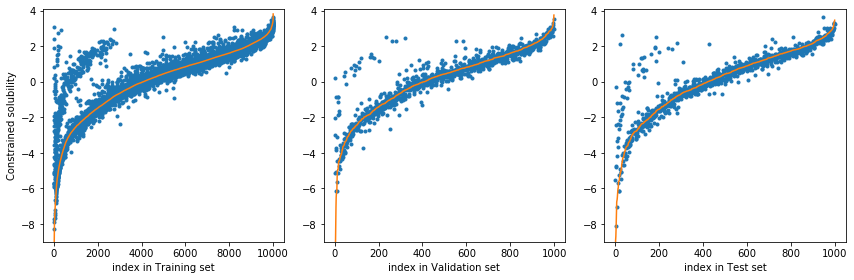

In [11]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(131)
plt.plot([x for _,x in sorted(zip(trainset.graph_labels,preds_train))],'.')
plt.plot(sorted(trainset.graph_labels))
plt.ylim(-9, 4.1)
ax1.set_xlabel('index in Training set')
ax1.set_ylabel('Constrained solubility')

ax2 = plt.subplot(132)
plt.plot([x for _,x in sorted(zip(valset.graph_labels,preds_val))],'.')
plt.plot(sorted(valset.graph_labels))
plt.ylim(-9, 4.1)
ax2.set_xlabel('index in Validation set')

ax3 = plt.subplot(133)
plt.plot([x for _,x in sorted(zip(testset.graph_labels,preds_test))],'.')
plt.plot(sorted(testset.graph_labels))
plt.ylim(-9, 4.1)
ax3.set_xlabel('index in Test set')

plt.tight_layout()

plt.show()